# Create a Land/Ocean Mask from PNG File

I was looking for a 1° land mask for MODIS data, and for some reason the only one I found quickly was provided as an png image.

Here is the link: https://modis-images.gsfc.nasa.gov/MOD08_M3/grids.html

This was baffling, as I don't think of png files as really being useful for anything other than **seeing** the data. A quick search suggested that I could get numeric values out of the image, like that web page says.

This notebook shows how to get that image, read it into a numpy array, and process it into a useful land/ocean mask.

In [10]:
# Download & Save the image

import requests # to get image from the web
import shutil # to save it locally

image_url = 'https://modis-images.gsfc.nasa.gov/MOD08_M3/mask2.png'

image_file = '/Users/brianpm/Downloads/modis_landocean_image.png'  # the file where we save the image

# Open the url image, set stream to True, this will return the stream content.
r = requests.get(image_url, stream = True)
# Check if the image was retrieved successfully
if r.status_code == 200:
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    r.raw.decode_content = True
    # Open a local file with wb ( write binary ) permission.
    with open(image_file,'wb') as f:
        shutil.copyfileobj(r.raw, f)


In [13]:
# Reading png image file into a numpy array
import matplotlib.image as img

land_png = img.imread(image_file)

# land_png is now a numpy array
print(f"Shape of the land_png array: {land_png.shape}")

# The data is latitude x longitude x RGBA color.
# That is *NOT* what the web page described. I don't know whether that's because of different ways of decode png or what, but
# having the colors is pretty good.

# One important thing to note is that the alpha value is all 1, so we can ignore alpha:
print(f"The minimum and maximum of the 'A' value: {land_png[:,:,-1].min()}, {land_png[:,:,-1].max()}")

#
# We can convert RGB triplets to gray scale with a formula.
# I found this here: https://www.delftstack.com/howto/python/convert-image-to-grayscale-python/
#
imgGray = 0.2989 * land_png[:,:,0] + 0.5870 * land_png[:,:,1] + 0.1140 * land_png[:,:,2]
print(f"Resulting grayscale array is shaped: {imgGray.shape}")

Shape of the land_png array: (180, 360, 4)
The minimum and maximum of the 'A' value: 1.0, 1.0
Resulting grayscale array is shaped: (180, 360)


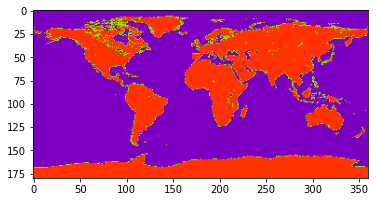

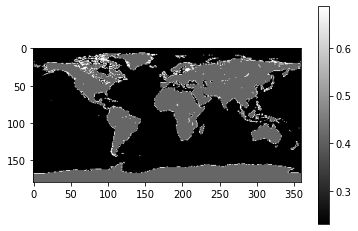

In [20]:
# At this point, we should also check the image in color and grayscale:
import matplotlib.pyplot as plt

plt.imshow(land_png)
plt.show()

plt.imshow(imgGray, cmap='gray')
plt.colorbar()
plt.show()

## Convert to xarray

At this point, we have a 180x360 array of values between 0 and 1. For easier use later, we can turn this array into an xarray DataArray with coordinates and metadata. 

In absence of other data we could use the information from the web page to derive the coordinates:

    The first (upper left) grid position (1,1) corresponds to a 1 degree box centered at latitude 89.5 and longitude -179.5. The convention used here is positive latitudes are degrees north and positive longitudes are degrees east, allowing lat/lon pairs to increase from top to bottom and left to right on the grid. Therefore, the first grid (1,1) corresponds to a 1 degree box centered at 89.5N and 179.5W.



In [28]:
import numpy as np
lon = np.linspace(-179.5, 179.5, 360)
assert len(lon) == imgGray.shape[1], "Failed to make longitude same size as in image"
lat = np.linspace(89.5, -89.5, 180)
assert len(lat) == imgGray.shape[0], "Failed to make latitude same size as in image"
# note that latitude is north-to-south, which is not always the convention we want. 

# turn these lat and lon arrays into DataArrays
import xarray as xr
lon = xr.DataArray(lon, dims="lon", attrs={"name":"lon", "long_name":"Longitude", "units":"degrees_east"})
lat = xr.DataArray(lat, dims="lat", attrs={"name":"lat", "long_name":"Latitude", "units":"degrees_north"})

[0.23045765 0.41399807 0.68773454]


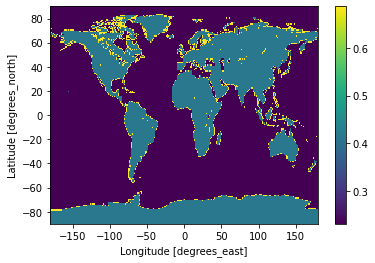

In [53]:
final_attrs = {"comment":"derived from png: https://modis-images.gsfc.nasa.gov/MOD08_M3/mask2.png"}
modis_landsea = xr.DataArray(imgGray , dims=("lat","lon"), coords={"lat":lat, "lon":lon}, attrs=final_attrs)

# this is nearly done, but I'd like to convert the values to more intuitive ones:
# ocean : 0
# land : 1
# mixed: 0.5

# 1. get a look at the new version
modis_landsea.plot.pcolormesh()

# 2. print the unique values that we have in the array:
uniqvals = np.unique(modis_landsea)
print(uniqvals)
# --> [0.23045765 0.41399807 0.68773454]
#      Ocean      Land       Mixed

# One could alter the values by just normalizing between 0 and 1:
# modis_landsea = (modis_landsea - np.min(modis_landsea)) / (np.max(modis_landsea) - np.min(modis_landsea))
# This doesn't work because in our grayscale, the "Mixed" category is larger than the "Land" category
# So we just hard-code this:
modis_landsea = xr.where(modis_landsea == uniqvals[0], 0, modis_landsea)
modis_landsea = xr.where(modis_landsea == uniqvals[1], 1, modis_landsea)
modis_landsea = xr.where(modis_landsea == uniqvals[2], 0.5, modis_landsea)

# we lost attrs during that step:
modis_landsea.attrs = {**modis_landsea.attrs, **final_attrs}

# as a convenience (for me), switch latitude to be -90 to 90:
modis_landsea = modis_landsea.reindex(lat=modis_landsea.lat[::-1])
modis_landsea.name = "landmask" 

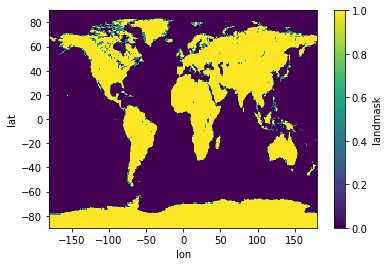

In [54]:
# confirm that this still looks good:
modis_landsea.plot.pcolormesh()


In [55]:
#
# Output 
#
outfilename = "/Users/brianpm/Downloads/MODIS_1degree_landmask.nc"
enc = {"landmask": {'_FillValue':-9999}, "lat":{'_FillValue':None}, "lon":{'_FillValue':None}}

modis_landsea.to_netcdf(outfilename, encoding=enc)